 Our goal is to recover the tensor $X\in R^{n_1\times n_2\dots \times n_d}$ from linear meauseremetns $A(X) = b$. For this purpose we wil use TT-decomposition of a tensor and solve the following problem: 
$$\min\limits_{r_1\dots r_{d-1}} \quad n_1r_1 + r_1n_2r_2+r_2n_3r_3 +\dots +r_{d-2}n_{d-1}r_{d-1}+ r_{d-1}n_d $$

By substituting $r_i, \  i = \overline{1, d-1}$ with $ \|\cdot{\|}_{*} $ we will get the following problem:

$$\min \limits_{X_{(1)}, \dots, {X_{(d-1)}}} n_1\|X_{(1)}{\|}_* + n_2\|X_{(1)}{\|}_*\|X_{(2)}{\|}_*+\dots+ n_{d-1}\|X_{(d-2)}{\|}_*\|X_{(d-1)}{\|}_*+ n_d\|X_{(d-1)}{\|}_*, $$
$$s.t: \quad  X_\Omega = T_\Omega, $$


where $X_{(i)}$ is the mode - $i$ matricization of the tensor $X$, which rank is equal to $r_i$, $\Omega - $ some index subset.

We can rewrite the initial optimization problem to the equal form:
$$\min\limits_{X, M_k}\  n_1\|M_1{\|}_*+ \sum\limits_{k = 1}^{d-1} {n_{k+1}\|M_k{\|}_*\|M_{k+1}{\|}_*+\frac{\beta_k}{2}\|X_k-M_k{\|}_F^2}$$
$$ s.t. X_{\Omega} = T_{\Omega} $$
Let's solve this problem using ALS scheme:

** 1. Optimization over $M_k , \ k = \overline{1, d-1}:$ **
equals to
$$ \min\limits_{M_k} \  (n_k\|M_{k-1}{\|}_*+n_{k+1}\|M_{k+1}{\|}_*)\|M_k{\|}_*+\frac{\beta_k}{2}\|X_k-M_k{\|}_F^2 $$
after substitution
$$\alpha_k  = n_k\|M_{k-1}{\|}_*+n_{k+1}\|M_{k+1}{\|}_*, \quad \|M_0{\|}_* = \|M_d{\|}_* = 1$$
we will get:
$$ \min\limits_{M_k} \  \alpha_k\|M_k{\|}_*+\frac{\beta_k}{2}\|X_k-M_k{\|}_F^2 $$

the solution of this problem is
$$ \hat{M_k} = Shrink_{\frac{\alpha_k}{\beta_k}}(X_k)  $$
### Question: how can we deal with the forward scheme for $\alpha_k$? (we need to know the $\|M_{k+1}{\|}_*$ for each $ \alpha_{k}$).

** 2. Optimization over the tensor $X$ **

After the updating the all of the $M_k, k = \overline{1, d-1}$ on the prvious step, we can update the tensor $X$:

\begin{equation}
X_{i_1i_2\dots i_d} = 
\begin{cases}
\frac {\sum\limits_{k=1}^{d-1}{\beta_k Fold(M_k)}}{\sum\limits_{k = 1}^{d-1}{\beta_k}}, & i_1, i_2, \dots, i_d \notin \Omega\\
t_{i_1\dots i_d}, & i_1, i_2, \dots, i_d \in \Omega
\end{cases}
\end{equation}



In [2]:
%matplotlib inline
import matplotlib.pylab as pylab
from scipy.io import loadmat
import numpy as np
import numpy.linalg as nlin
import tt 
import matplotlib.pyplot as plt

/home/elvira/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [10]:
def vec_shrink(x, nu):
    return np.maximum(x-nu, np.zeros(np.shape(x)))

def Shrink(X, nu):
    u,s,v = nlin.svd(X, full_matrices=False)
    s_new = vec_shrink(s, nu)
    return np.dot(u, np.dot(np.diag(s_new), v))

# Getting the mode-k matricization of tensor T:
def unfold(T, k):
    d = len(np.shape(T))
    
    if (k < 1):
        print 'The second parameter k should be >= 1'
        return -1
    if (k >= d):
        print 'The second parameter k should be <= d-1'
        return -1
    
    shapes = np.shape(T)
    N = np.prod(shapes[0:k])
    M = np.prod(shapes[k:d])
    return np.reshape(T, (N, M))

# Function folds the matrix M to the tensor with dimensions, storing in array shapes:
def fold(M, shapes):
    return np.reshape(M, shapes)

d = 4
n = np.array([15, 15, 15, 15], dtype = np.int)
alpha = np.zeros(d-1)
beta = np.zeros(d-1)
delta = np.zeros(d-1)
for k in xrange(d-1):
    first = 1.
    second = 1.
    for l in xrange(k+1):
        first *= n[l]
    for l in xrange(k+1, d):
        second *= n[l]
    #print first, second
    #print np.minimum(first, second)
    delta[k] = np.minimum(first, second)
    
alpha = delta/np.sum(delta)
flist = [0.01, 0.05, 0.1, 0.5, 1]
maxiter = 1000
rank = 3
T0 = tt.rand(n, d, rank) 
T = T0.full()
X = np.random.randn(15, 15, 15, 15)
ro = 0.7
p = np.int(ro*n[0]**d )## number of missed entries in X
q = np.int(n[0]**d-p ) ## entires of X that we know
indexes = np.random.randint(n[0], size = (p, 4))
for k in xrange(p):
    T[indexes[k, 0], indexes[k, 1], indexes[k, 2], indexes[k, 3]] = 0

In [11]:
def SimpleTT(X, T, maxiter, d, alpha, beta):
    arr = np.where(T != 0)
    np.shape(np.transpose(arr))
    index_set = np.transpose(arr)
    errors = np.zeros(maxiter)
    for i in xrange(maxiter):
        for k in range(d-1):
            X_k = unfold(X, k+1)
            M_k = Shrink(X_k, alpha[k]/beta[k])
        X = np.sum(beta)*fold(M_k, n)/np.sum(beta)
        for j in index_set:
            X[j[0], j[1], j[2], j[3]] = T[j[0], j[1], j[2], j[3]]
        errors[i] = nlin.norm(X-T0.full())/nlin.norm(T0.full())
    return X, errors
f = 0.1 
beta = f*alpha
X_rec, er = SimpleTT(X, T, maxiter, d, alpha, beta)



#for f in flist:
#    beta = alpha*f
#    X_rec, er = SimpleTT(X, T, maxiter, d, alpha, beta)
#    err.append(er)

[ 0.72817196  0.71504948  0.70228627  0.68986095  0.67775141  0.6659356
  0.65439237  0.64310227  0.63204819  0.62121548  0.61059194  0.60016748
  0.58993381  0.57988411  0.57001275  0.56031505  0.55078713  0.54142577
  0.5322283   0.52319244  0.51431624  0.50559791  0.49703578  0.48863729
  0.48039673  0.47231069  0.46437663  0.45659237  0.44895588  0.4414652
  0.43411842  0.42692058  0.41987428  0.41297244  0.40621087  0.39958651
  0.39309685  0.38674021  0.38052811  0.37445292  0.3685098   0.36269498
  0.35700525  0.35144855  0.34601932  0.3407111   0.33551971  0.3304419
  0.32547483  0.32063308  0.3159073   0.31128998  0.30677649  0.30236333
  0.29806392  0.29386956  0.2897737   0.28577207  0.28186137  0.27803884
  0.27430792  0.27066916  0.26711826  0.26367252  0.26031865  0.25704899
  0.25385816  0.25074208  0.24769751  0.24472183  0.2418128   0.23896849
  0.23618717  0.23346728  0.23080946  0.22822032  0.22569487  0.22322996
  0.22082318  0.21847252  0.21617622  0.2139327   0.21

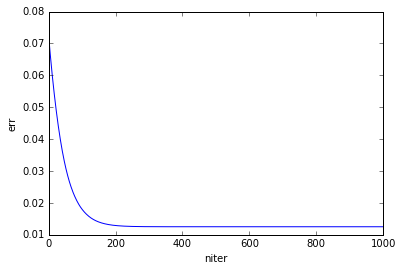

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(er)
plt.xlabel('niter')
plt.ylabel('err')
plt.savefig('one of the optimal.png')

In [3]:
ranks = [1, 2, 3, 4, 5, 6,  7, 8, 9, 10, 11, 12, 13, 14, 15]
rolist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mlist = []
for ro in rolist:
    mlist.append(50625*ro)


rate_matrix = np.zeros((len(ranks), len(mlist)))
u = 0
o = 0
for rank in ranks:
    print rank
    for m in mlist:
        print m
        rate = 0.
        for w in range(10):
            T0 = tt.rand(n, d, rank) 
            T = T0.full()
            X = np.random.randn(15, 15, 15, 15)
            p = np.int(ro*n[0]**d )## number of missed entries in X
            q = np.int(n[0]**d-p ) ## entires of X that we know
            indexes = np.random.randint(n[0], size = (p, 4))
            for k in xrange(p):
                T[indexes[k, 0], indexes[k, 1], indexes[k, 2], indexes[k, 3]] = 0
            X_rec, er = SimpleTT(X, T, maxiter, d, alpha, beta)
            if er[len(er)]<0.2:
                rate +=1.
        rate_matrix[u,o] = rate/50625
        o += 1
    u += 1    

1
5062.5


NameError: name 'n' is not defined

In [79]:

plt.figure()
i = np.int(0)
for f in flist:
    plt.plot(err[i], label = 'f = {}'.format(f))
    i = i + np.int(1)
plt.legend()
plt.xlabel('niter')
plt.ylabel('err')
plt.savefig('Simple_TT.png')

IndexError: list index out of range

Now lets solve the folowwing optimization problem:

$$\min\limits_{X, M_k, \Lambda_k} n_1\|M_1{\|}_*+ \sum\limits_{k = 1}^{d-1} {n_{k+1}\|M_k{\|}_*\|M_{k+1}{\|}_* \  + <\Lambda_k, X_k-M_k{>}_F+\frac{\beta_k}{2}\|X_k-M_k{\|}_F^2}  $$
$$s.t \quad X_{\Omega} = T_{\Omega} $$
Using ALS we will get the three optimization problems (over the three parameteres $\Lambda_k, M_k, X$):

**Over $\Lambda_k$ : **
\begin{equation}
\begin{split}
&\min\limits_{\Lambda_k} <\Lambda_k, X_k-M_k{>}_F \\
& f(\Lambda_k) =  <\Lambda_k, X_k-M_k{>}_F  \\
&\bigtriangledown f_k = X_k - M_k \\
Then,\  &\Lambda_k = \Lambda_k - \mu(X_k-M_k)
\end{split}
\end{equation}

** Over $X$ : **
$$ \min\limits_{X}  <\Lambda_k, X_k-M_k{>}_F + \frac{\beta_k}{2}\|X_k-M_k{\|}_F^2  $$
$$s.t \quad X_{\Omega} = T_{\Omega} $$
We can rewrite this problem in the form:
$$ \min\limits_{X} \ \sum_{k = 1}^{d-1} \frac{\beta_k}{2}\|X_k-M_k+\frac{1}{\beta_k}\Lambda_k {\|}^2_F $$
$$s.t \quad X_{\Omega} = T_{\Omega} $$
We will use the following update for $X$:
\begin{equation}
X_{i_1i_2\dots i_d} = 
\begin{cases}
\frac {\sum\limits_{k=1}^{d-1}{\beta_k Fold(M_k-\frac{1}{\beta_k}\Lambda_k)}}{\sum\limits_{k = 1}^{d-1}{\beta_k}}, & i_1, i_2, \dots, i_d \notin \Omega\\
t_{i_1\dots i_d}, & i_1, i_2, \dots, i_d \in \Omega
\end{cases}
\end{equation}
** Over $M_k$ : **
$$ \min\limits_{M_k} \ (n_k\|M_{k-1}{\|}_*+n_{k+1}\|M_{k+1}{\|}_*)\|M_k{\|}_* + <\Lambda_k, X_k-M_k{>}_F + \frac{\beta_k}{2}\|X_k-M_k{\|}_F^2  $$

or
$$\min\limits_{M_k} \ (n_k\|M_{k-1}{\|}_*+n_{k+1}\|M_{k+1}{\|}_*)\|M_k{\|}_* +  \frac{\beta_k}{2}\|X_k-M_k+\frac{1}{\beta_k}\Lambda_k{\|}_F^2$$

In [3]:
######### for d = 3 #########
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
import numpy as np
import numpy.linalg as nlin
import tt 

def vec_shrink(x, nu):
    return np.maximum(x - nu, np.zeros(np.shape(x))

def Shrink(X, nu):
    u,s,v = nlin.svd(X, full_matrices=False)
    s_new = vec_shrink(s, nu)
    return np.dot(u, np.dot(np.diag(s_new), v))
                      
def fold(M, shapes):
    return np.reshape(M, shapes)
                      
def update_Lambda(L, X, mu):
    return L-mu*(X-L)
                
def update_M(alpha, beta, X):
    return Shrink(X, alpha/beta)                  

def update_X(betas, M1, Lambda1, M2, Lambda2, index_set, T):
    X = beta1*fold(M1-Lambda1/beta1,)

In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
from scipy.io import loadmat
import numpy as np
import numpy.linalg as nlin
import tt 
import matplotlib.pyplot as plt

def vec_shrink(x, nu):
    return np.maximum(x - nu, np.zeros(np.shape(x)))

def Shrink(X, nu):
    u,s,v = nlin.svd(X, full_matrices=False)
    s_new = vec_shrink(s, nu)
    return np.dot(u, np.dot(np.diag(s_new), v))

def updateL(L, A,  mu):
    return L - mu*A


def get_alphas(X):
    shapes = np.shape(X)
    d = len(shapes)
    norms = np.zeros(d+1)
    alphas = np.zeros(d-1)
    norms[0] = 1
    norms[d] = 1
    for k in range(1, d):
        norms[k] = nlin.norm(np.reshape(X,(np.prod(shapes[:k+1]), np.prod(shapes[k+1:]))) , 'nuc')
    for k in range(d-1):
        alphas[k] = shapes[k]*norms[k]+shapes[k+1]*norms[k+1]
    return alphas
    
###### here X0 - the initial tensor ##############
###### M - tensor ########
###### L ####
def Algorithm1(X0, M, L0, T, maxiter,f):
    shapes  = np.shape(X)
    i_set = np.transpose(np.where(T != 0))
    d = len(shapes)
    L  = L0
    for i in xrange(maxiter):
        alphas  = get_alphas(M)
        betas = f*alphas
        M_list = []
        ######################## update all of the M_k  ###########################
        for k in range(d-1):
            X_k = np.reshape(X, (np.prod(shapes[:k+1]), np.prod(shapes[k+1:])))
            M_k = Shrink(X_k + L/beta[k])
            M_list.append(M_k)
        X_k = np.reshape(X, )

In [27]:
X = np.random.randn(3,4, 5)
shapes = np.shape(X)
k = 
(np.prod(shapes[:k+1]), np.prod(shapes[k+1:]))

(60, 1.0)

In [39]:


X = np.random.randn(2, 2, 2)
get_alphas(X)

array([ 7.24555964,  9.32186189])

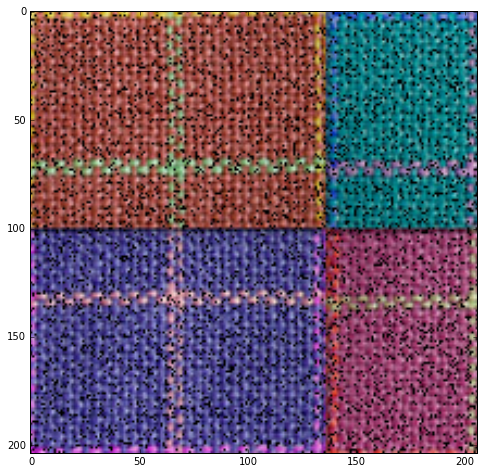

In [2]:
%matplotlib inline
import matplotlib.pylab as pylab
from scipy.io import loadmat
import numpy as np
pylab.rcParams['figure.figsize'] = 8, 8
mat = loadmat("image_crop.mat")
im = mat["im"]

m, n, k = im.shape
im_recovered = np.zeros([m,n,k])
im_missed = np.zeros([m,n,k])
ro = np.random.rand(m,n) > 0.1
for i in range(3):
    im_missed[:,:,i] = im[:,:,i]*ro
im_missed = im_missed.astype(im.dtype)
pylab.imshow(im_missed)

In [5]:
from cvxopt import matrix
from numpy import array
A = matrix([[1,2,3],[4,5,6]])
print(A)

[ 1  4]
[ 2  5]
[ 3  6]



In [1]:
from cvxopt import matrix, normal, spdiag, misc, lapack
from ubsdp import ubsdp

m, n = 50, 50
A = normal(m**2, n)

# Z0 random positive definite with maximum e.v. less than 1.0.
Z0 = normal(m,m)
Z0 = Z0 * Z0.T
w = matrix(0.0, (m,1))
a = +Z0
lapack.syev(a, w, jobz = 'V')
wmax = max(w)
if wmax > 0.9:  w = (0.9/wmax) * w
Z0 = a * spdiag(w) * a.T

# c = -A'(Z0)
c = matrix(0.0, (n,1))
misc.sgemv(A, Z0, c, dims = {'l': 0, 'q': [], 's': [m]}, trans = 'T', alpha = -1.0)

# Z1 = I - Z0
Z1 = -Z0
Z1[::m+1] += 1.0

x0 = normal(n,1)
X0 = normal(m,m)
X0 = X0*X0.T
S0 = normal(m,m)
S0 = S0*S0.T
# B = A(x0) - X0 + S0
B = matrix(A*x0 - X0[:] + S0[:], (m,m))

X = ubsdp(c, A, B)

ImportError: No module named ubsdp

In [6]:
for i in range(3):
    im2 = im_missed[:,:,i]
    im3 = np.zeros([m,n])
    lambd = 0.001
    error = 1000.0
    
    while error > 1:
        for j in range(20):
            temp = ro*im2 + (1-ro)*im3;
            U, S, V = np.linalg.svd(temp,full_matrices=False)
            im3 = np.dot(np.dot(U,np.diag(np.maximum( S-1.0 / lambd,0))),V)
            
        error = np.linalg.norm((im2-im3)*ro)
        print "error = ",error
            
        lambd = lambd + 0.1*error
        
    im_recovered[:,:,i] = im3
    
    

error =  4821.49109791
error =  0.0253135610183
error =  3860.47854154
error =  0.0314210971965
error =  4236.49317913
error =  0.0286958944852


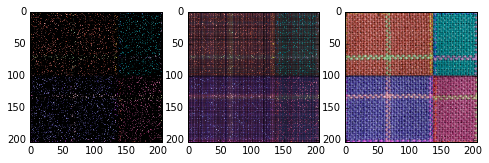

In [4]:
pylab.subplot(1,3,1)
pylab.imshow(im_missed.astype(im.dtype))

pylab.subplot(1,3,2)
pylab.imshow(im_recovered.astype(im.dtype))

pylab.subplot(1,3,3)
pylab.imshow(im.astype(im.dtype))

### Now lets try Tensor-Train approach (using Lena's image)

In [4]:
import numpy as np
import tt
from tt.maxvol import maxvol
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
lena = Image.open("lena.png")

im = np.array(lena)
m, n, k = im.shape
im_recovered = np.zeros([m,n,k])
im_missed = np.zeros([m,n,k])
ro = np.random.rand(m,n) > 0.8

for i in range(3):
    im_missed[:,:,i] = im[:,:,i]*ro
im_missed = im_missed.astype(im.dtype)

im_tt = tt.tensor(im, 1e-3)
im_missed_tt = tt.tensor(im_missed)
im_recovered_tt = tt.tensor(im_recovered)


def shrink(x, delta):
    if np.abs(x) < delta:
        return 0
    else:
        return x-delta


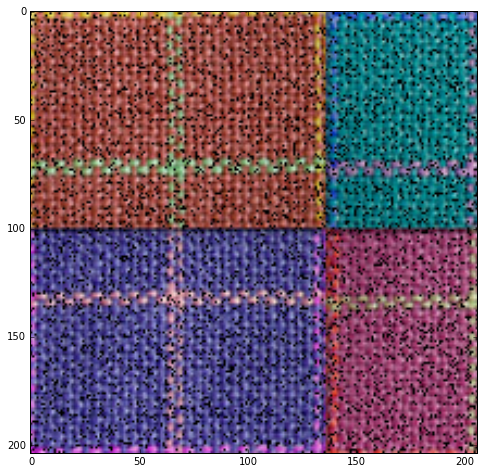

In [4]:
plt.imshow(im_missed)

In [5]:
import numpy as np
n = 
A = np.zeros((n*n, n*n))

SyntaxError: invalid syntax (<ipython-input-5-4d4f9868d0fa>, line 2)

In [29]:
im_tt = tt.tensor(im, 1e-20)

In [30]:
np.shape(im_tt.core)

(167697,)

In [12]:
from scipy.sparse import bsr_matrix
N = 257
bsr_matrix((N*N, N*N), dtype=np.complex).toarray()

MemoryError: 

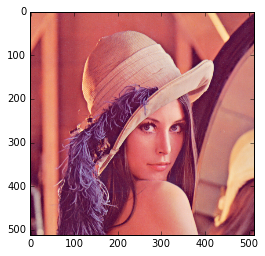

In [41]:
from PIL import Image
#from transforms import RGBTransform # from source code mentioned above

lena = Image.open("lena.png")
#lena = lena.convert('RGB') # ensure image has 3 channels
plt.imshow(lena)
lena = np.array(lena)

## Matrix completion

In [8]:
import cvxopt


In [34]:
a = misc.lena()

NameError: name 'misc' is not defined